In [1]:
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2

/home/xabush/moses-incons-pen-xp


In [70]:
import pyximport; pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7fe6f81dbfd0>)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from notebooks.variable_selection.util import *
from notebooks.variable_selection.grad_util import *
from sklearn.model_selection import train_test_split, KFold
from autograd import elementwise_grad as egrad
import scipy
%matplotlib inline
plt.style.use('ggplot')

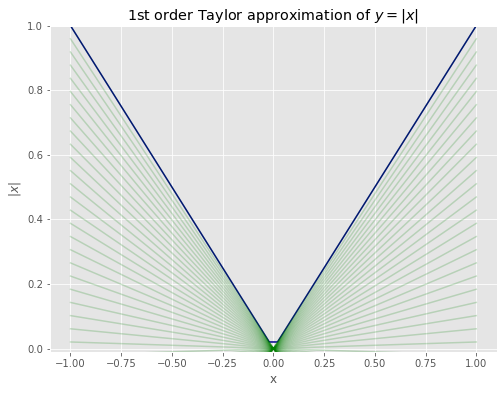

In [12]:
x2 = np.linspace(-1, 1, 50)
y2 = np.abs(x2)

slopes2 = x2

lines2 = [slopes2[i]*x2 for i in range(len(x2))]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x2, y2, color="darkblue")
[ax.plot(x2, lines2[i], color = 'green', alpha = .2) for i in range(len(x2))]
ax.set_ylim(-.01,1)
ax.set_xlabel('x')
ax.set_ylabel('$|x|$')
plt.title('1st order Taylor approximation of $y = |x|$')
plt.show()

In [389]:
from sklearn.model_selection import train_test_split, KFold
X_lin, beta_lin, y_lin = generate_data_v2(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7)
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, test_size=0.5)

In [390]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_lin_train)
X_train = scaler.transform(X_lin_train)
X_test = scaler.transform(X_lin_test)

In [391]:
scaler_y = StandardScaler().fit(y_lin_train.reshape(-1, 1))
y_train = scaler_y.transform(y_lin_train.reshape(-1, 1))
y_test = scaler_y.transform(y_lin_test.reshape(-1, 1))

In [392]:
assoc_mat = get_assoc_mat(200, 10, corr=0.7)

In [393]:
L_norm = scipy.sparse.csgraph.laplacian(assoc_mat, normed=True)
L_norm = L_norm + 1e-14*np.identity(L_norm.shape[0])

In [394]:
U, D, V = scipy.linalg.svd(L_norm)

In [395]:
D = np.diag(D)
J  = np.sqrt(D) @ V

In [396]:
J.shape

(2200, 2200)

In [228]:
L_d = np.linalg.cholesky(L_norm)

In [215]:
np.allclose(L_norm, (L_d @ L_d.T))

True

In [360]:
from sklearn.linear_model import lasso_path
gamma_vals = np.logspace(-3, 0, 10)
l2_vals = np.logspace(-2, 1, 10)

In [371]:
from sklearn.linear_model import LassoCV
n, p = X_lin_train.shape
zeros = np.zeros((p, 1))
n_alpha = 10
alphas = np.zeros(len(l2_vals))
coefs = np.zeros((len(l2_vals), p))
r2_errs = np.zeros(len(l2_vals))

for i, l2 in enumerate(l2_vals):
    # c = 1/np.sqrt(1 + l2)
    S = np.sqrt(l2*n) * J
    X_p = np.concatenate((X_train, S), axis=0)
    # X_p = X_stack
    y_p = np.concatenate((y_train, zeros), axis=0)
    y_p = np.ravel(y_p)
    clf = LassoCV(max_iter=10000, alphas=np.array([0.01])).fit(X_p, y_p)
    r2_errs[i] = clf.score(X_train, y_train)
    coefs[i] = clf.coef_
    alphas[i] = clf.alpha_

/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

In [372]:
r2_errs

array([0.97008095, 0.97073657, 0.97127683, 0.97164618, 0.97102164,
       0.96965385, 0.96632068, 0.96354566, 0.96140862, 0.95986677])

In [363]:
l2_vals

array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])

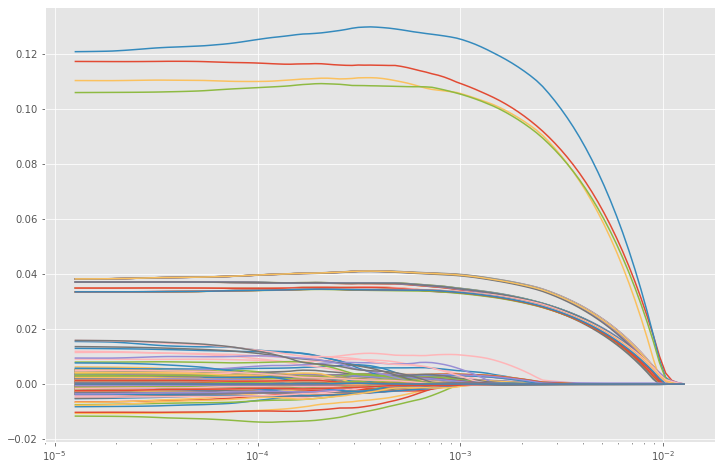

In [411]:
from sklearn.linear_model import LarsCV
n, p = X_train.shape
S = np.sqrt(100*n) * J
X_p = np.concatenate((X_train, S), axis=0)
# X_p = (1/np.sqrt(1 + 0.1))*X_p
y_p = np.concatenate((y_train, np.zeros((p, 1))), axis=0)
y_p = np.ravel(y_p)
alphas, coefs, _ = lasso_path(X_p, y_p)
plt.figure(figsize = (12,8))
for i in range(p):
    plt.plot(alphas, coefs[i])
    plt.xscale('log')


In [414]:

clf1 = LassoCV(max_iter=10000, normalize=False, alphas=np.array([0.001])).fit(X_p, y_p)
clf1.score(X_train, y_train)

/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9651050566596309

In [406]:
clf2 = LassoCV(max_iter=10000, normalize=False, alphas=np.array([0.01])).fit(X_train, np.ravel(y_train))
print(clf2.score(X_train, np.ravel(y_train)))
clf2.score(X_test, np.ravel(y_test))

0.9989590918337988


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9173744746209257

In [415]:
y_pred_1 = clf1.predict(X_test)
y_pred_2 = clf2.predict(X_test)
print(mean_squared_error(y_test, y_pred_1))
print(mean_squared_error(y_test, y_pred_2))

0.05376856844893277
0.0765501988188978


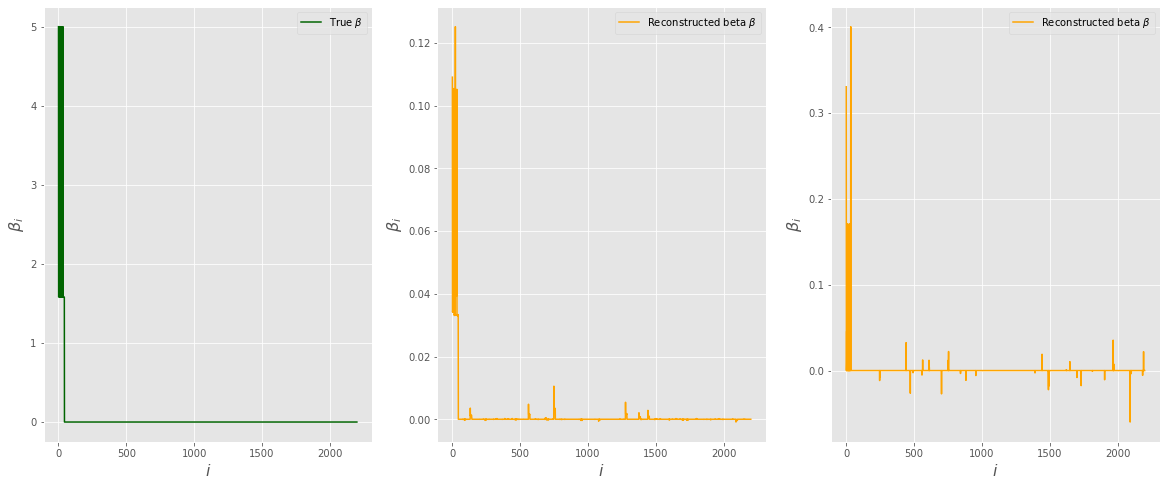

In [491]:
# plt.plot(beta_lin, label=r"True $\beta$")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
ax[0].plot(beta_lin, label=r"True $\beta$", color="darkgreen")
ax[0].set_xlabel(r"$i$", fontsize=16)
ax[0].set_ylabel(r"$\beta_i$", fontsize=16)
ax[0].legend(loc="upper right")
ax[1].plot(clf1.coef_, label=r"Reconstructed beta $\beta$", color="orange")
ax[1].set_xlabel(r"$i$", fontsize=16)
ax[1].set_ylabel(r"$\beta_i$", fontsize=16)
ax[1].legend(loc="upper right")
ax[2].plot(clf2.coef_, label=r"Reconstructed beta $\beta$", color="orange")
ax[2].set_xlabel(r"$i$", fontsize=16)
ax[2].set_ylabel(r"$\beta_i$", fontsize=16)
ax[2].legend(loc="upper right")

In [128]:
from sklearn.svm._base import _fit_liblinear
from sklearn.linear_model import LogisticRegression

array([3.37951325e+00, 1.21453409e+00, 4.36480921e-01, 1.56863110e-01,
       5.63736787e-02, 2.02596497e-02, 7.28094058e-03, 2.61663438e-03,
       9.40369637e-04, 3.37951325e-04])

In [7]:
from sklearn.model_selection import train_test_split, KFold

X_log, beta_log, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5)

In [528]:
assoc_mat_log = get_assoc_mat(20, 10)

In [1353]:
X_log, beta_log, y_log = generate_log_data(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5)
assoc_mat_2 = get_assoc_mat(200, 10, 0.7)
L_norm = scipy.sparse.csgraph.laplacian(assoc_mat_2, normed=True)

In [1331]:
idx_z_train = np.where(y_log_train == 0)
idx_z_test = np.where(y_log_test == 0)
y_log_train[idx_z_train] = -1
y_log_test[idx_z_test] = -1

In [1132]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_log_train)
X_log_train = scaler.transform(X_log_train)
X_log_test = scaler.transform(X_log_test)

In [1361]:
from notebooks.variable_selection.logistic_coordinate_descent import *


test_err, betas, test_loss = coordinate_descent(X_log_train, X_log_test, y_log_train, y_log_test, L_norm, [0.01, 0.1, 1], [0.1, 0.3, 0.56], max_iter=200)

lambda: 0.01
lambda: 0.1
lambda: 1


In [ ]:
import warnings
from notebooks.variable_selection.logistic_coordinate_descent import *
warnings.filterwarnings("ignore")
n_sim = 1
train_errs_cv = np.zeros(n_sim)
test_errs = np.zeros(n_sim)
# beta_vals_cv_2 = np.zeros((n_sim, n_iter, n_iter, X_train.shape[1]))
beta_vals = np.zeros((n_sim, X_log_train.shape[1]))

l1_vals = np.logspace(-3, 1, 5)
l2_vals = np.logspace(-1, 0, 5)

test_ll_pen = np.zeros((n_sim))
min_l1_vals, min_l2_vals = np.zeros(n_sim), np.zeros(n_sim)

assoc_mat_2 = get_assoc_mat(200, 10, 1)
L = scipy.sparse.csgraph.laplacian(assoc_mat_2, normed=True)

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
for i in range(n_sim):
    X_log, beta_log, y_log = generate_log_data(200, 10, tf_on=4, val_tf=[5, -5, 3, -3], corr=0.7, n=100)
    X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5, stratify=y_log)
    fold_test_errs = np.zeros((n_folds, l1_vals.shape[0], l2_vals.shape[0]))
    fold_beta_vals = np.zeros((n_folds, l1_vals.shape[0], l2_vals.shape[0], X_log_train.shape[1]))
    fold_ll_pen = np.zeros((n_folds, l1_vals.shape[0], l2_vals.shape[0]))
    # fold_l1_pen = np.zeros((n_folds, l1_vals.shape[0], l2_vals.shape[0]))
    # fold_l2_pen = np.zeros((n_folds, l1_vals.shape[0], l2_vals.shape[0]))
    j = 0
    for train_idx, test_idx in cv.split(X_log_train, y_log_train):
        print(f"[{datetime.now()}] - fold - {j + 1}")
        x_train_cv, x_test_cv = X_log_train[train_idx], X_log_train[test_idx]
        y_train_cv, y_test_cv = y_log_train[train_idx], y_log_train[test_idx]
        fold_test_errs[j], fold_beta_vals[j],\
                fold_ll_pen[j] = coordinate_descent(x_train_cv, x_test_cv, y_train_cv, y_test_cv, L, l1_vals, l2_vals, max_iter=200)

        j += 1
    fold_cv_err = np.mean(fold_test_errs, axis=0)
    min_idx = np.unravel_index(np.argmin(fold_cv_err), fold_cv_err.shape)

    train_errs_cv[i] = fold_cv_err[min_idx]
    # train_ll_pen[i] = np.mean(fold_ll_pen, axis=0)[min_idx]
    # train_l1_pen[i] = np.mean(fold_l1_pen, axis=0)[min_idx]
    #
    # train_l2_pen[i] = np.mean(fold_l2_pen, axis=0)[min_idx]

    min_l1_val, min_l2_val = l1_vals[min_idx[0]], l2_vals[min_idx[1]]
    min_l1_vals[i] = min_l1_val
    min_l2_vals[i] = min_l2_val
    test_errs[i], beta_vals[i], \
        test_ll_pen[i] = apply_coordinate_descent(X_log_train, X_log_test, y_log_train, y_log_test,
                                                                              L, min_l1_val, min_l2_val, max_iter=200)

[2022-03-08 12:36:48.179768] - fold - 1
lambda: 0.001
lambda: 0.01
lambda: 0.1
lambda: 1.0
lambda: 10.0
[2022-03-08 12:46:20.345057] - fold - 2
lambda: 0.001
lambda: 0.01
lambda: 0.1
lambda: 1.0


In [1364]:
test_err

array([[0.66061835, 0.66790354, 0.67833267],
       [0.68621032, 0.69314718, 0.69314718],
       [0.69314718, 0.69314718, 0.69314718]])

In [3]:
from notebooks.variable_selection.cdn import CDN
X_log, beta_log, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5, stratify=y_log)
y_log_train_c = y_log_train.copy()
y_log_test_c = y_log_test.copy()
y_log_train_c[y_log_train_c == 0] = -1
y_log_test_c[y_log_test_c == 0] = -1
assoc_mat_2 = get_assoc_mat(20, 10, 1)
L = scipy.sparse.csgraph.laplacian(assoc_mat_2, normed=True)

In [1547]:
from notebooks.variable_selection.cdn import CDN
cdn = CDN(C=0.1, D=1)
cdn.fit(X_log_train, y_log_train_c, L, verbose=2, randomize=False, max_epochs=3, max_ls=100)
cdn.get_w()

epoch 0, delta=13.99909, rel_change=1.00000, ls_steps=0, q_pen=1.927
epoch 1, delta=2.41424, rel_change=0.19646, ls_steps=98094, q_pen=1.991
epoch 2, delta=0.59370, rel_change=0.04962, ls_steps=102078, q_pen=2.064
Maximum epochs exceeded; stopping after 2 epochs


array([0.55800667, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [4]:
import lrb
model = lrb.LogisticRegressionBounded(C=0.01, D=0.1)
model.fit(X_log_train, y_log_train, L, verbose=2, randomize=False, max_epochs=50, tol=1e-3)

IndexError: Out of bounds on buffer access (axis 1)

Exception ignored in: 'lrb.compute_hessian_element'
Traceback (most recent call last):
  File "/tmp/ipykernel_14087/1869875326.py", line 3, in <module>
IndexError: Out of bounds on buffer access (axis 1)


ZeroDivisionError: float division

In [32]:
probs = sigmoid(X_log_test @ model.coef_[0])
log_loss(y_log_test, probs)

TypeError: 'NoneType' object is not subscriptable

In [35]:
model._w[0]

array([1.11916715, 0.        , 0.16460181, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
import traceback
from autograd import hessian, jacobian
from notebooks.variable_selection.log_util import log_msg

n_sim = 10
n_c = 10
c_vals = np.append([0.0], np.geomspace(0.01, 1, num=n_c - 1))
d_vals = np.append([0.0], np.geomspace(0.01, 100, n_c - 1))
train_errs = np.zeros((n_sim))
test_errs = np.zeros((n_sim))
min_c_vals = np.zeros(n_sim)
min_d_vals = np.zeros(n_sim)
betas = np.zeros((n_sim, 220))

cv = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
assoc_mat_2 = get_assoc_mat(20, 10, 0.7)
L = scipy.sparse.csgraph.laplacian(assoc_mat_2, normed=True)
try:
    for n in range(n_sim):
        log_msg(f"Sim - {n + 1}")
        X_log, beta_log, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
        X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5, stratify=y_log)

        train_cv_err = np.zeros((n_c, n_c))
        for i, c in enumerate(c_vals):
            for k, d in enumerate(c_vals):
                cdn = CDN(C=c, D=d)
                fold_errs = np.zeros(n_folds)
                j = 0
                for train_idx, test_idx in cv.split(X_log_train, y_log_train):
                    x_train_cv, x_test_cv = X_log_train[train_idx], X_log_train[test_idx]
                    y_train_cv, y_test_cv = y_log_train[train_idx], y_log_train[test_idx]
                    cdn.fit(x_train_cv, y_train_cv, L, randomize=False, max_epochs=100)
                    probs = sigmoid(cdn.get_w(), x_test_cv)
                    fold_errs[j] = log_loss(y_test_cv, probs)
                    j += 1
                train_cv_err[i, k] = np.mean(fold_errs)

        min_idx = np.unravel_index(np.argmin(train_cv_err), train_cv_err.shape)
        train_errs[n] = train_cv_err[min_idx]
        min_c = c_vals[min_idx[0]]
        min_d = d_vals[min_idx[1]]
        min_c_vals[n] = min_c
        min_d_vals[n] = min_d

        cdn = CDN(C=min_c, D=min_d)
        cdn.fit(X_log_train, y_log_train, L, randomize=False, max_epochs=100)
        w_n = cdn.get_w()
        probs = sigmoid(w_n, X_log_test)
        t_err = log_loss(y_log_test, probs)
        print(f"C={min_c}, D={min_d}, test_err: {t_err}")
        test_err[n] = t_err
        betas[n] = w_n

    log_msg("Done")

except Exception as e:
    log_msg("Oh, no! An error occurred. Here is the error message")
    log_msg(traceback.format_exc())

Sim - 1


In [1541]:
test_errs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1396]:
def sig(b, X, y):
    return 1/(1 + np.exp(-y*(X @ b)))

In [1404]:
y_log_train_c = y_log_train.copy()
y_log_train_c[y_log_train_c == 0]  = -1
grad_1 = (X_log_train.T) @ (y_log_train_c * (sig(beta_log, X_log_train, y_log_train_c) - 1))
grad_1[0]

2.762156234332652

In [1425]:
b = np.array([2.0, 3.0])
A = np.array([[2.0, 1.0], [1.0, 2.0]])
grad(quad_form_coef)(b, A)[0]

14.0

In [1428]:
2 *( A[0] @ b)

14.0

In [1408]:
u = sig(beta_log, X_log_train, y_log_train_c)
D = np.diag(u * (1 - u))
hess_1 = X_log_train.T @ D @ X_log_train
hess_1[2, 2]

1.029452334283484

In [4]:
%load_ext cython

In [5]:
%%cython
import numpy as np
cimport cython
DTYPE = np.intc

cdef int clip(int a, int min_value, int max_value):
    return min(max(a, min_value), max_value)


@cython.boundscheck(False)
@cython.wraparound(False)
def compute(int[:, :] array_1, int[:, :] array_2, int a, int b, int c):
    cdef Py_ssize_t x_max = array_1.shape[0]
    cdef Py_ssize_t y_max = array_1.shape[1]

    assert tuple(array_1.shape) == tuple(array_2.shape)

    result = np.zeros((x_max, y_max), dtype=DTYPE)
    cdef int[:,:] result_view = result

    cdef int tmp
    cdef Py_ssize_t x, y

    for x in range(x_max):
        for y in range(y_max):
            tmp = clip(array_1[x, y], 2, 10)
            tmp = tmp * a + array_2[x, y] * b
            result_view[x, y] = tmp + c

    return result

In [23]:
array_1 = np.asfortranarray(np.random.uniform(0, 1000, size=(50, 2000)).astype(np.double).T)
array_2 = np.asfortranarray(np.random.uniform(0, 1000, size=(50, 2000)).astype(np.double))

In [3]:
%load_ext cython

In [91]:
%%cython
import numpy as np
cimport numpy as np
from scipy.linalg.cython_blas cimport dgemm, dgemv, ddot
from cython cimport boundscheck, wraparound



@boundscheck(False)
@wraparound(False)
cpdef int fast_dgemm_1(double[::1, :] a, double[::1, :] b, double[::1, :] c, double alpha=1.0, double beta=0.0) nogil except -1:
    cdef:
        char* transa = 'n'
        char* transb = 'n'
        int m, n, k, lda, ldb
        double *a0=&a[0, 0]
        double *b0=&b[0, 0]
        double *c0=&c[0, 0]

    lda = a.shape[0]
    ldb = b.shape[0]

    m = a.shape[0]
    n = b.shape[1]
    k = a.shape[1]

    dgemm(transa, transb, &m, &n, &k, &alpha, a0, &lda, b0, &ldb, &beta, c0,  &m)

    return 0

@boundscheck(False)
@wraparound(False)
cpdef int fast_dgemm(double[:, :] a, double[:, :] b, double[:, :] c, double alpha=1.0, double beta=0.0,
            int ta = 0, int tb = 0) nogil except -1:
    cdef:
        char* transa
        char* transb
        int m, n, k, lda, ldb
        double *a0=&a[0, 0]
        double *b0=&b[0, 0]
        double *c0=&c[0, 0]

    if ta == 0:
        transa = 'n'
        m = a.shape[0]
        k = a.shape[1]
        lda = m
    elif ta == 1:
        transa = 't'
        m = a.shape[1]
        k = a.shape[0]
        lda = k

    if tb == 0:
        transb = 'n'
        ldb = k
        n = b.shape[1]
    elif tb == 1:
        transb = 't'
        n = b.shape[0]
        ldb = n

    dgemm(transa, transb, &m, &n, &k, &alpha, a0, &lda, b0, &ldb, &beta, c0,  &m)

    return 0


@boundscheck(False)
@wraparound(False)
cpdef int fast_dgemm_3(double[:] a, double[:, :] b, double[:] c, double alpha=1.0, double beta=0.0, int t = 0) nogil except -1:
    cdef:
        char* transb
        int m, n, k, lda, ldb
        double *a0=&a[0]
        double *b0=&b[0,0]
        double *c0=&c[0]

    if t == 0:
       transb = 'n'
    else:
        transb = 't'

    m = b.shape[0]
    n = b.shape[1]
    k = 1

    dgemv(transb, &m, &n, &alpha, b0, &m, a0, &k, &beta, c0, &k)

    return 0

@boundscheck(False)
@wraparound(False)
cpdef double fast_dot_prod(double[:] a, double[:] b, double beta=0.0) nogil:
    cdef:
        double *a0=&a[0]
        double *b0=&b[0]
        int k
        int n

    n = a.shape[0]
    k = 1

    return ddot(&n, a0, &k, b0, &k)

@boundscheck(False)
@wraparound(False)
cpdef int fast_mat_vec_prod_1(double[:,:] a, double[:] b, double[:] c, double beta=0.0) nogil except -1:

    cdef:
        double *a0
        double *b0 = &b[0]
        int k
        int n

    n = a.shape[0]
    k = 1

    for i in range(n):
        a0 = &a[i, 0]
        c[i] = ddot(&n, a0, &k, b0, &k)

    return 0

@boundscheck(False)
@wraparound(False)
cpdef int fast_mat_vec_prod_2(double[:,:] a, double[:] b, double[:] c, double beta=0.0) nogil except -1:

    cdef:
        double *a0
        double *b0 = &b[0]
        int k
        int n
        double s

    n = a.shape[0]
    k = 1

    for i in range(n):
        s = 0
        for j in range(n):
            s += b[j] * a[j, i]
        c[i] = s

    return 0

@boundscheck(False)
@wraparound(False)
cpdef double fast_quad_form(double[:] b, double[:,:] A):

    cdef double[:] res1 = np.zeros(b.shape[0])
    fast_mat_vec_prod_2(A, b, res1)
    return fast_dot_prod(res1, b)

@boundscheck(False)
@wraparound(False)
cpdef double compute_grad_j(double[:] probs, int yX_j_start, int yX_j_length, int[:] yX_rows, double[:] yX_vals, double[:,:] A):
    cdef double[:] p = np.zeros(probs.shape[0])
    cdef double g2 = 0.0
    cdef double[:,:] e= np.diag(probs)
    if fast_mat_vec_prod_1(A, probs, p) == -1:
        raise ValueError("Error in matrix-vector product")

    cdef int i = yX_j_start
    cdef int index
    cdef u = 0.0
    while (i < yX_j_start + yX_j_length):
        index = yX_rows[i]
        u = probs[index]
        g2 += 2 * p[index] * u * (1 - u) * yX_vals[i]
        i += 1

    return g2

# def hess_quad_form(b, X, A):
#     f = sigmoid(X @ b)
#     u = f * (1 - f)
#     e = (A @ f) *(u * (1 - 2*f))
#     D = np.diag(u)
#     E = np.diag(e)
#     # p = 2 * (L @ X)
#     return 2 * (X.T @ (E + (D @ A @ D)) @ X)

@boundscheck(False)
@wraparound(False)
cpdef double compute_hessian_element(double[:] probs, int yX_j_start, int yX_j_length, int[:] yX_rows, double[:] yX_vals, double[:, :] A):

    cdef double h2 = 0.0
    cdef int lim = yX_j_start + yX_j_length
    cdef double[:] p = np.zeros(probs.shape[0])
    cdef double[:,:] m = np.zeros((1, yX_j_length))
    cdef double[:,:] r = np.zeros((1, yX_j_length))
    cdef double[:,:] D = np.zeros((probs.shape[0], probs.shape[0]))
    cdef double[:,:] E = np.zeros((probs.shape[0], probs.shape[0]))
    cdef double[:, :] R1 = np.zeros((probs.shape[0], probs.shape[0]))
    cdef double[:, :] R2 = np.zeros((probs.shape[0], probs.shape[0]))
    cdef double[:, :] R3 = np.zeros((probs.shape[0], probs.shape[0]))
    cdef int i = yX_j_start
    cdef int index

    fast_mat_vec_prod_1(A, probs, p)

    while (i < lim):
        index = yX_rows[i]
        u = probs[index] * (1 - probs[index])
        D[index, index] = u
        E[index, index] = p[index] * u * (1 - 2 * probs[index])
        i += 1

    m[0] = yX_vals[yX_j_start:lim]
    fast_dgemm(D, A, R1)
    fast_dgemm(R1, D, R2)

    for k in range(probs.shape[0]):
        for j in range(probs.shape[0]):
            R3[k, j] = E[k, j] + R2[k, j]

    fast_dgemm(m, R3, r)
    h2 = 2 * fast_dot_prod(r[0], m[0])

    return h2

In file included from /home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/xabush/.cache/ipython/cython/_cython_magic_182e0d6260a60ec76aee9adda4eb08ae.c:725:
/home/xabush/miniconda3/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~
/home/xabush/.cache/ipython/cython/_cython_magic_182e0d6260a60ec76aee9adda4eb08ae.c: In function '__pyx_f_46_cython_magic_182e0d6260a60ec76aee9adda4eb08ae_fast_dgemm.isra.7':
/home/xabush/.cache/ipython/cython/_cython_magic_182e0d

In [155]:
X_log, beta_log, y_log = generate_log_data(2000, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.5, stratify=y_log)

In [ ]:
assoc_mat_2 = get_assoc_mat(200, 10)
prec_mat = get_emp_covariance(X_log_train, assoc_mat_2)
L = get_laplacian_mat(X_log_train, X_log_train, prec_mat, 1, norm=True)
probs = sigmoid(X_log_train @ beta_log)
# X_j_starts, X_j_lengths, X_rows, X_vals = get_indices(X_log_train)

In [92]:
compute_hessian_element(probs, X_j_starts[131], X_j_lengths[131], X_rows, X_vals, L)

-0.19317646359861243

In [43]:
e = np.zeros(X_log_train.shape[1])
for j in range(len(e)):
   e[j] = compute_grad_j( probs, X_j_starts[j], X_j_lengths[j], X_rows, X_vals, L)

In [93]:
e = np.identity(X_log_train.shape[1])
for i in range(X_log_train.shape[1]):
    e[i, i] = compute_hessian_element(probs, X_j_starts[i], X_j_lengths[i], X_rows, X_vals, L)

In [94]:
np.allclose(np.diag(e), np.diag(h1), atol=1e-4)

True

In [152]:
import lrb_lvm as lvm

cdn_3 = lvm.LogisticRegressionBounded(C=0.3, D=0.03)
sr = scipy.sparse.coo_matrix(X_log_train)
cdn_3.fit(sr, y_log_train, L, verbose=2)

Initial Background pen 0.00190 - reloaded v2
C=0.30000, D=0.03000
epoch 0, delta=11.80463, rel_change=1.00000, ls_steps=0, avg. log_loss=0.04504, bp_pen=2.10349, lasso_pen=1.44886
epoch 1, delta=1.74713, rel_change=0.16874, ls_steps=27850, avg. log_loss=0.04413, bp_pen=1.74524, lasso_pen=1.37193
epoch 2, delta=0.12428, rel_change=0.01197, ls_steps=27593, avg. log_loss=0.04276, bp_pen=1.76692, lasso_pen=1.35874
epoch 3, delta=0.01856, rel_change=0.00178, ls_steps=34289, avg. log_loss=0.04238, bp_pen=1.77248, lasso_pen=1.35871
epoch 4, delta=0.00018, rel_change=0.00002, ls_steps=33206, avg. log_loss=0.04238, bp_pen=1.77254, lasso_pen=1.35871
epoch 5, delta=0.00000, rel_change=0.00000, ls_steps=36214, avg. log_loss=0.04238, bp_pen=1.77254, lasso_pen=1.35871
relative change below tolerance; stopping after 5 epochs


In [153]:
cdn_3.coef_

array([0.81041343, 0.0756557 , 0.38644872, ..., 0.        , 0.        ,
       0.        ])

In [154]:
log_loss_cp(X_log_test, y_log_test, cdn_3.coef_)

0.32640266716958877

In [9]:
from notebooks.variable_selection.grad_util import grad_quad_form
def grad_quad_form(b, X, A):
    f = sigmoid(X @ b)
    u = f * (1 - f)
    D = np.diag(u)
    p = 2 * (A @ f)
    return p.T @ D @ X

def hess_quad_form(b, X, A):
    f = sigmoid(X @ b)
    u = f * (1 - f)
    e = (A @ f) *(u * (1 - 2*f))
    D = np.diag(u)
    E = np.diag(e)
    # p = 2 * (L @ X)
    return 2 * (X.T @ (E + (D @ A @ D)) @ X)

def get_indices(X):
    X_csc = scipy.sparse.coo_matrix(X).tocsc()
    X_j_starts = np.zeros(X.shape[1], dtype=np.int32)
    X_j_lengths = np.zeros(X.shape[1], dtype=np.int32)
    X_rows = []
    X_vals = []
    index = 0
    for j in range(X.shape[1]):
        X_j_coo = X_csc[:, j].tocoo()
        X_j_length = len(X_j_coo.data)
        X_j_starts[j] = index
        X_j_lengths[j] = X_j_length
        for row, val in zip(X_j_coo.row, X_j_coo.data):
            X_rows.append(row)
            X_vals.append(val)
        index += X_j_length
    X_rows = np.array(X_rows, dtype=np.int32)
    X_vals = np.array(X_vals)

    return X_j_starts, X_j_lengths, X_rows, X_vals

In [94]:
g1 = grad_quad_form(beta_log, X_log_train, L)

In [134]:
 X_j_starts, X_j_lengths, X_rows, X_vals = get_indices(X_log_train)

In [138]:
X_vals.shape

(11000,)

In [34]:
A_csc = scipy.sparse.coo_matrix(A).tocsc()
A_csc

<5x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Column format>

In [41]:
yX_rows

array([0, 1, 4, 0, 1, 0, 3, 0, 4, 2], dtype=int32)

In [42]:
yX_vals

array([ 5, 12,  7,  2,  2,  4,  4,  6,  1, 12])